<a href="https://colab.research.google.com/github/serasset/llod-cloud-evaluator/blob/main/Wrapping_SPARQL_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wrapping SPARQL queries and using them in python

First, we use SPARQLWrapper and we add utility functions to get the results as a panda dataframe.


In [1]:
%%capture 
!pip3 install rdflib sparqlwrapper pydotplus graphviz

In [2]:
import rdflib
from rdflib import Graph
from rdflib.namespace import DC, RDF, FOAF, RDFS
from rdflib import URIRef, BNode, Literal
import networkx as nx
import io
import pydotplus
from IPython.display import display, Image
from rdflib.tools.rdf2dot import rdf2dot

In [3]:
# Helper function for vizualizing RDF graph
def visualize(g):
    stream = io.StringIO()
    rdf2dot(g, stream, opts = {display})
    dg = pydotplus.graph_from_dot_data(stream.getvalue())
    png = dg.create_png()
    display(Image(png)) 

In [20]:
# CLASS SPARQLEndpoint that ease the use of SPARQL queries in python
from SPARQLWrapper import SPARQLWrapper, JSON, POST, GET, POSTDIRECTLY, CSV, TURTLE
import requests
import pandas as pd
pd.set_option('display.max_colwidth', None)

import functools

def withReturnFormat(result_format):
    def decorator_withReturnFormat(func):
        @functools.wraps(func)
        def wrapper_withReturnFormat(self, *args, **kwargs):
          previous_format = self.wrapper.returnFormat
          self.wrapper.setReturnFormat(result_format)
          value = func(self, *args, **kwargs)
          self.wrapper.setReturnFormat(previous_format)
          return value
        return wrapper_withReturnFormat
    return decorator_withReturnFormat

class SPARQLEndpoint:
  
  def __init__(self, sparql_endpoint, http_query_method=POST, result_format=JSON, token=None):
    self.wrapper = SPARQLWrapper(sparql_endpoint)

    #sparql_client.addCustomHttpHeader("Content-Type", "application/sparql-query")
    if token:
        self.wrapper.addCustomHttpHeader("Authorization","Bearer {}".format(token))
    self.wrapper.setMethod(http_query_method)
    self.wrapper.setReturnFormat(result_format)
    if http_query_method == POST:
        self.wrapper.setRequestMethod(POSTDIRECTLY)
    
  def query(self, query):
    self.wrapper.setQuery(query)
    return self.wrapper.queryAndConvert()

  # Convert SPARQL results into a Pandas data frame
  def sparql2dataframe(self, json_sparql_results):
    cols = json_sparql_results['head']['vars']
    out = []
    for row in json_sparql_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)
    return pd.DataFrame(out, columns=cols)
  
  def query_as_dataframe(self, query):
    return self.sparql2dataframe(self.query(query))
    
  @withReturnFormat(TURTLE)
  def construct(self, query):
    self.wrapper.setQuery(query)
    g = Graph()
    g.parse(self.wrapper.query().convert())
    return g

In [21]:
dbnary = SPARQLEndpoint('http://kaiko.getalp.org/sparql')

results = dbnary.query_as_dataframe("""
SELECT ?l, ?f WHERE {
    
  ?le a ontolex:LexicalEntry ;
        rdfs:label "chat"@fr;
        ^lime:entry / dcterms:language lexvo:fra ;
        ^dbnary:isTranslationOf ?tr.
    ?tr dbnary:targetLanguage ?l;
        dbnary:writtenForm ?f.
}
""")

results


,l,f
0,http://lexvo.org/id/iso639-3/aar,bissa
1,http://lexvo.org/id/iso639-3/abx,miyong
2,http://lexvo.org/id/iso639-3/afr,kat
3,http://lexvo.org/id/iso639-3/afr,kat
4,http://lexvo.org/id/iso639-3/agn,kosi
...,...,...
399,http://lexvo.org/id/iso639-3/yij,buthi
400,http://lexvo.org/id/iso639-3/zdj,paha
401,http://lexvo.org/id/iso639-3/zho,猫
402,http://lexvo.org/id/iso639-3/zho,猫


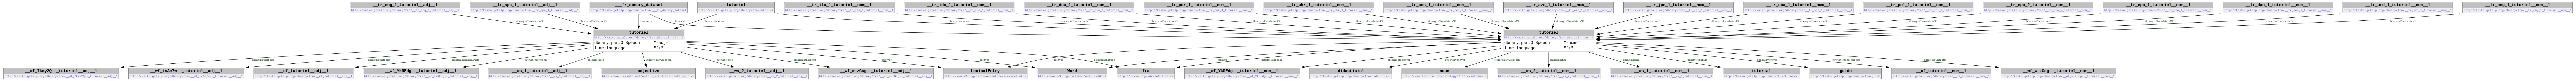

In [24]:
graph = dbnary.construct("""
CONSTRUCT {?le ?p ?v. ?s ?ip ?le} WHERE {
  {
    ?le a ontolex:LexicalEntry ;
        rdfs:label "tutoriel"@fr;
        ^lime:entry / dcterms:language lexvo:fra.
    OPTIONAL {?le ?p ?v}
    OPTIONAL {?s ?ip ?le}
  }
}
""")

visualize(graph)

In [26]:
print(graph.serialize(TURTLE))

[a rdfg:Graph;rdflib:storage [a rdflib:Store;rdfs:label 'Memory']].


In [16]:
chat = dbnary.query("DESCRIBE <http://kaiko.getalp.org/dbnary/fra/chat__nom__1>")

chat

b'@prefix dbnary:\t<http://kaiko.getalp.org/dbnary#> .\n@prefix dbnary-fra:\t<http://kaiko.getalp.org/dbnary/fra/> .\ndbnary-fra:__tr_aar_1_chat__nom__1\tdbnary:isTranslationOf\tdbnary-fra:chat__nom__1 .\ndbnary-fra:__tr_abx_1_chat__nom__1\tdbnary:isTranslationOf\tdbnary-fra:chat__nom__1 .\ndbnary-fra:__tr_afr_1_chat__nom__1\tdbnary:isTranslationOf\tdbnary-fra:chat__nom__1 .\ndbnary-fra:__tr_afr_2_chat__nom__1\tdbnary:isTranslationOf\tdbnary-fra:chat__nom__1 .\ndbnary-fra:__tr_agn_1_chat__nom__1\tdbnary:isTranslationOf\tdbnary-fra:chat__nom__1 .\ndbnary-fra:__tr_aka_1_chat__nom__1\tdbnary:isTranslationOf\tdbnary-fra:chat__nom__1 .\ndbnary-fra:__tr_alt_1_chat__nom__1\tdbnary:isTranslationOf\tdbnary-fra:chat__nom__1 .\ndbnary-fra:__tr_ang_1_chat__nom__1\tdbnary:isTranslationOf\tdbnary-fra:chat__nom__1 .\ndbnary-fra:__tr_any_1_chat__nom__1\tdbnary:isTranslationOf\tdbnary-fra:chat__nom__1 .\ndbnary-fra:__tr_ara_1_chat__nom__1\tdbnary:isTranslationOf\tdbnary-fra:chat__nom__1 .\ndbnary-fra:_